In [129]:
import numpy as np
import pandas as pd 

In [130]:
columns = ['start','end','length','material','MoI']
data = [[0,1,3,210e9,0.3e-6]]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,length,material,MoI
0,0,1,3,2.100000e+11,3.000000e-07


In [131]:
w = 10000 # uniform load in N/m
L = elements.loc[0,'length']
# creating nodes
columns = ['coordinate','displacement','slope','load','moment']
data = [[0,0,0,np.nan,np.nan],
        [3,np.nan,np.nan,-w*L/2,w*L*L/12]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate,displacement,slope,load,moment
0,0,0.0,0.0,NaN,NaN
1,3,NaN,NaN,-15000.0,7500.0


In [132]:
def compute_localK(element):
    L = element['length']
    c = element['material']*element['MoI']/(L**3)
    k = np.array([[12, 6*L, -12, 6*L],
                [6*L, 4*L*L, -6*L, 2*L*L],
                [-12, -6*L, 12, -6*L],
                [6*L, 2*L*L, -6*L, 4*L*L]])*c
    return k
elements['k'] = elements.apply(compute_localK,axis=1)
elements

,start,end,length,material,MoI,k
0,0,1,3,2.100000e+11,3.000000e-07,"[[28000.0, 42000.0, -28000.0, 42000.0], [42000..."


In [133]:
elements.loc[0,'k']

array([[ 28000.,  42000., -28000.,  42000.],
       [ 42000.,  84000., -42000.,  42000.],
       [-28000., -42000.,  28000., -42000.],
       [ 42000.,  42000., -42000.,  84000.]])

In [134]:
N = len(nodes)
def compute_globalK(element):
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)
    K = np.zeros([N*2,N*2])
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['k']
    return K
K = elements.apply(compute_globalK,axis=1).sum()
K

array([[ 28000.,  42000., -28000.,  42000.],
       [ 42000.,  84000., -42000.,  42000.],
       [-28000., -42000.,  28000., -42000.],
       [ 42000.,  42000., -42000.,  84000.]])

In [135]:
def partition_k(K, A, B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement','slope']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load','moment']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K,A,B)

In [136]:
# known displacements, UB
UB = U[B]
# known loads, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

In [137]:
results = nodes.copy()
results[['displacement','slope']] = U.reshape(-1,2)
results[['load','moment']] = P.reshape(-1,2)
results.round(3)

,coordinate,displacement,slope,load,moment
0,0,0.000,0.000,15000.0,37500.0
1,3,-1.607,-0.714,-15000.0,7500.0


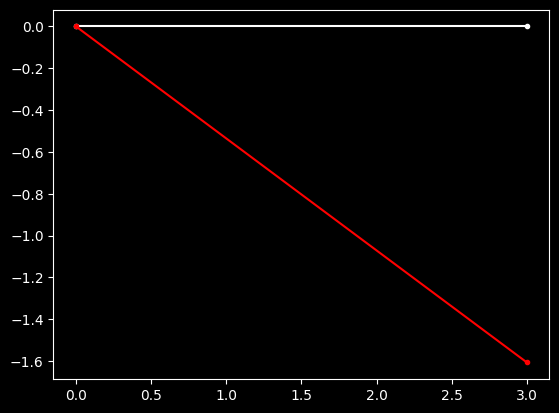

In [138]:
import matplotlib.pyplot as plt

y = np.zeros(N)
plt.style.use('dark_background')
plt.plot(results['coordinate'],y,'w.-')

plt.plot(results['coordinate'],results['displacement'],'r.-')
#plt.ylim([-1.8,1.8])
plt.show()

In [139]:
F0 = np.array([-w*L/2,-w*L*L/12,-w*L/2,w*L*L/12])
Fe = results[['load','moment']].to_numpy()
Fe = Fe.reshape(1,-1)
F = (Fe-F0).reshape(-1,2)
results[['globalForce','globalMoment']] = F
results

,coordinate,displacement,slope,load,moment,globalForce,globalMoment
0,0,0.000000,0.000000,15000.0,37500.0,30000.0,45000.0
1,3,-1.607143,-0.714286,-15000.0,7500.0,0.0,0.0


### Cantilever beam with point load

In [164]:
columns = ['start','end','length','material','MoI']
data = [[0,1,3,210e9,0.3e-6],
        [1,2,3,210e9,0.3e-6]]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,length,material,MoI
0,0,1,3,2.100000e+11,3.000000e-07
1,1,2,3,2.100000e+11,3.000000e-07


In [165]:
columns = ['coordinate','displacement','slope','load','moment']
data = [[0,0,0,np.nan,np.nan],
        [3,np.nan,np.nan,-10000,0]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate,displacement,slope,load,moment
0,0,0.0,0.0,NaN,NaN
1,3,NaN,NaN,-10000.0,0.0


In [166]:
df = nodes.loc[len(nodes)-1]
nodes.loc[len(nodes)-1] = [1.5, np.nan, np.nan, 0, 0]
nodes = nodes.append(df,ignore_index=True)
nodes

C:\Users\BhargavNaidu\AppData\Local\Temp\ipykernel_21440\732608417.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes = nodes.append(df,ignore_index=True)


,coordinate,displacement,slope,load,moment
0,0.0,0.0,0.0,NaN,NaN
1,1.5,NaN,NaN,0.0,0.0
2,3.0,NaN,NaN,-10000.0,0.0


In [167]:
def compute_localK(element):
    L = element['length']
    c = element['material']*element['MoI']/(L**3)
    k = np.array([[12, 6*L, -12, 6*L],
                [6*L, 4*L*L, -6*L, 2*L*L],
                [-12, -6*L, 12, -6*L],
                [6*L, 2*L*L, -6*L, 4*L*L]])*c
    return k
elements['k'] = elements.apply(compute_localK,axis=1)
elements

,start,end,length,material,MoI,k
0,0,1,3,2.100000e+11,3.000000e-07,"[[28000.0, 42000.0, -28000.0, 42000.0], [42000..."
1,1,2,3,2.100000e+11,3.000000e-07,"[[28000.0, 42000.0, -28000.0, 42000.0], [42000..."


In [169]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)

    K = np.zeros([N*2,N*2])

    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['k']

    return K
K = elements.apply(compute_globalK,axis=1).sum()
K  


array([[ 28000.,  42000., -28000.,  42000.,      0.,      0.],
       [ 42000.,  84000., -42000.,  42000.,      0.,      0.],
       [-28000., -42000.,  56000.,      0., -28000.,  42000.],
       [ 42000.,  42000.,      0., 168000., -42000.,  42000.],
       [     0.,      0., -28000., -42000.,  28000., -42000.],
       [     0.,      0.,  42000.,  42000., -42000.,  84000.]])

In [170]:
def partition_k(K, A, B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement','slope']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load','moment']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K,A,B)

In [171]:
# known displacements, UB
UB = U[B]
# known loads, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

In [172]:
results = nodes.copy()
results[['displacement','slope']] = U.reshape(-1,2)
results[['load','moment']] = P.reshape(-1,2)
results.round(3)

,coordinate,displacement,slope,load,moment
0,0.0,0.000,0.000,10000.0,60000.0
1,1.5,-3.571,-2.143,0.0,0.0
2,3.0,-11.429,-2.857,-10000.0,0.0
